References:
- [sklearn](http://scikit-learn.org/stable/modules/outlier_detection.html) page
- [Kaggle](https://www.kaggle.com/victorambonati/unsupervised-anomaly-detection/notebook) page

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
%matplotlib inline

# Data

In [3]:
df = pd.read_csv("./data/NAB_data_corpus/realKnownCause/ambient_temperature_system_failure.csv")
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
timestamp    7267 non-null object
value        7267 non-null float64
dtypes: float64(1), object(1)
memory usage: 113.6+ KB


In [5]:
df.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


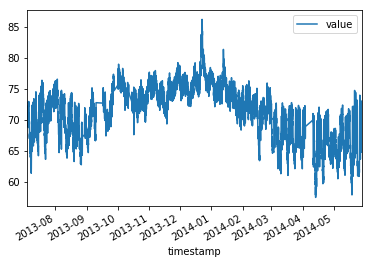

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.plot(x='timestamp', y='value')

In [7]:
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
# Change to Celsius degree
df['celsius'] = (df['value'] - 32) * 5 / 9
# Change to time epoch for later plotting
df['epoch'] = (df['timestamp'].astype(np.int64) / 100000000000).astype(np.int64)
df.head()

,timestamp,value,hour,dayofweek,celsius,epoch
0,2013-07-04 00:00:00,69.880835,0,3,21.044908,13728960
1,2013-07-04 01:00:00,71.220227,1,3,21.789015,13728996
2,2013-07-04 02:00:00,70.877805,2,3,21.598781,13729032
3,2013-07-04 03:00:00,68.959400,3,3,20.533000,13729068
4,2013-07-04 04:00:00,69.283551,4,3,20.713084,13729104


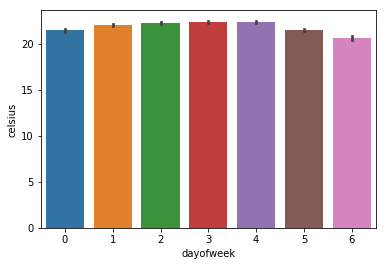

In [8]:
sns.barplot(data=df, x='dayofweek', y='celsius')

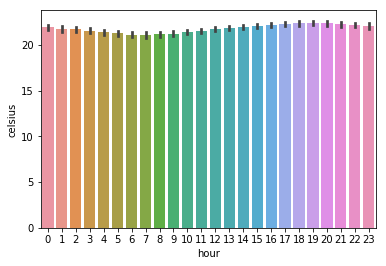

In [9]:
sns.barplot(data=df, x='hour', y = 'celsius')

# Models

There are actually two categories that have subtle difference: `novelty detection`, and `outlier detection`:
- Novelty detection: Training data has *no outliers*, and we are interested in detecting anomalies in new observations.
    - `One-class SVM` is popular for this.
- Outlier detection: Training data has outliers, and the work is to separate them from regular samples.

## K-means clustering

In [10]:
data = df[['value', 'hour', 'dayofweek']]
data_std = (data - data.mean()) / data.std()
data_std.describe()

,value,hour,dayofweek
count,7.267000e+03,7.267000e+03,7.267000e+03
mean,-1.244247e-14,1.100140e-16,-1.627064e-17
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.245202e+00,-1.661423e+00,-1.509425e+00
25%,-6.764016e-01,-8.674704e-01,-1.004360e+00
50%,1.450403e-01,7.083661e-02,5.768591e-03
75%,7.506811e-01,9.369662e-01,1.015898e+00
max,3.526956e+00,1.658741e+00,1.520962e+00


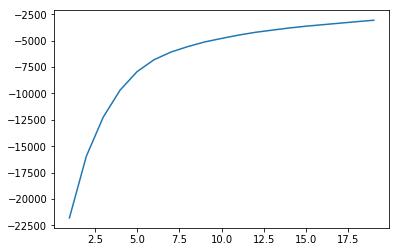

In [11]:
# Try different # of clusters
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data_std) for i in n_cluster]
scores = [kmeans[i].score(data_std) for i in range(len(kmeans))]
plt.plot(list(n_cluster), scores)

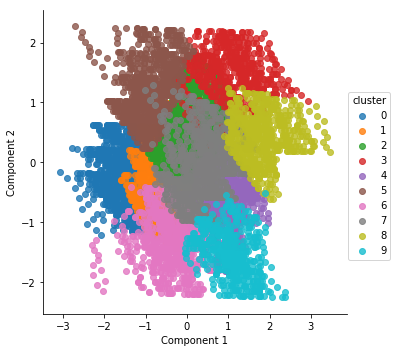

In [12]:
# The # of features is too small here, so we don't use PCA to extract features, but only for plotting 2D figure
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_std)

tmp_df = pd.DataFrame(data_2d, columns=["Component 1", "Component 2"])
tmp_df['cluster'] = kmeans[9].labels_  # We select 10-cluster model because it seems sufficient in the above plot
# Plot different clusters with different colors
sns.lmplot(data=tmp_df, x="Component 1", y = "Component 2", hue='cluster', fit_reg=False)

In [13]:
# Compute distance from each point to its cluster centroid, and pick out those outliers
outliers_fraction = 0.01
outliers_num = int(outliers_fraction * data_std.shape[0])
df['distance'] = np.min(kmeans[9].transform(data_std), axis = 1)
df['anomaly'] = df['distance'] > df['distance'].nlargest(outliers_num).min()
df.head()

,timestamp,value,hour,dayofweek,celsius,epoch,distance,anomaly
0,2013-07-04 00:00:00,69.880835,0,3,21.044908,13728960,0.809910,False
1,2013-07-04 01:00:00,71.220227,1,3,21.789015,13728996,0.850494,False
2,2013-07-04 02:00:00,70.877805,2,3,21.598781,13729032,0.693620,False
3,2013-07-04 03:00:00,68.959400,3,3,20.533000,13729068,0.349875,False
4,2013-07-04 04:00:00,69.283551,4,3,20.713084,13729104,0.250676,False


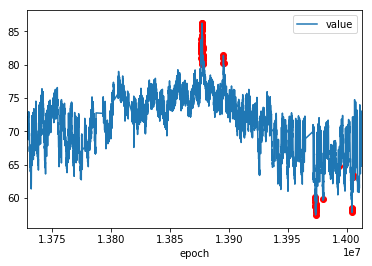

In [14]:
plt.figure()
df.plot(x='epoch', y='value')
plt.scatter(df.loc[df['anomaly'], 'epoch'], df.loc[df['anomaly'], 'value'], c='red')

## Elliptic Envelope

This method requires the data to be Gaussian distributed. It fits a ***robust*** covariance estimate to the data, and thus fits an ellipse to the central data points, ignoring points outside the central mode. 

In a naive estimate, the covariance is sensitive to outliers in the datset. HERE in Elliptic Envelope, `robust` comes from an important mechanism used in the algorithm, so that when estimating the covariance, only inlier samples are used (even though the samples are not actually labeled!!!).

To use this algorithm, we need to decide which features are Gaussian distributed. In the above data, only `value` might be Gaussian distributed. Therefore, other features should be either used to create sub groups, or simply discarded.

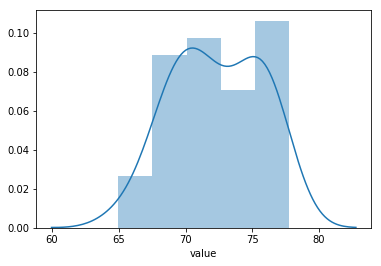

In [15]:
sns.distplot(df.loc[(df['hour'] == 0) & (df['dayofweek'] == 3), 'value'])

These two features create too many sub groups, making each group having a very small number of samples, which is not good for covariance estimate. So we want to make each group bigger by creating more general features from these two.

In [16]:
df['daylight'] = ((df['hour'] > 8) & (df['hour'] < 23)).astype(np.int)
df['weekday'] = ((df['dayofweek'] >= 0) & (df['dayofweek'] <=4)).astype(np.int)

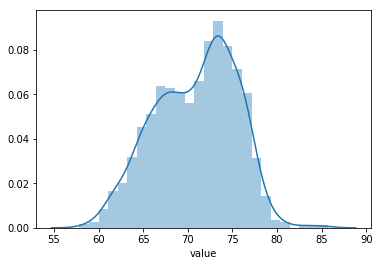

In [17]:
sns.distplot(df.loc[(df['daylight'] == 0) & (df['weekday'] == 1), 'value'])

In [18]:
df['anomaly'] = 0

In [19]:
group_0 = df.loc[(df['daylight'] == 0) & (df['weekday'] == 0), 'value']

ep_env_0 = EllipticEnvelope(contamination=outliers_fraction)
ep_env_0.fit(group_0.values.reshape(-1, 1))
pred_0 = ep_env_0.predict(group_0.values.reshape(-1, 1))
df.loc[(df['daylight'] == 0) & (df['weekday'] == 0), 'anomaly'] = pred_0

In [20]:
group_1 = df.loc[(df['daylight'] == 0) & (df['weekday'] == 1), 'value']
ep_env_1 = EllipticEnvelope(contamination=outliers_fraction)
ep_env_1.fit(group_1.values.reshape(-1, 1))
pred_1 = ep_env_1.predict(group_1.values.reshape(-1, 1))
df.loc[(df['daylight'] == 0) & (df['weekday'] == 1), 'anomaly'] = pred_1

In [21]:
group_2 = df.loc[(df['daylight'] == 1) & (df['weekday'] == 0), 'value']
ep_env_2 = EllipticEnvelope(contamination=outliers_fraction)
ep_env_2.fit(group_2.values.reshape(-1, 1))
pred_2 = ep_env_2.predict(group_2.values.reshape(-1, 1))
df.loc[(df['daylight'] == 1) & (df['weekday'] == 0), 'anomaly'] = pred_2

In [22]:
group_3 = df.loc[(df['daylight'] == 1) & (df['weekday'] == 1), 'value']
ep_env_3 = EllipticEnvelope(contamination=outliers_fraction)
ep_env_3.fit(group_3.values.reshape(-1, 1))
pred_3 = ep_env_3.predict(group_3.values.reshape(-1, 1))
df.loc[(df['daylight'] == 1) & (df['weekday'] == 1), 'anomaly'] = pred_3

In [23]:
df['anomaly'].value_counts()

 1    7193
-1      74
Name: anomaly, dtype: int64

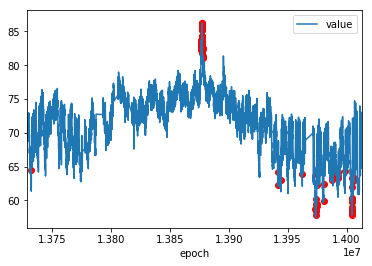

In [24]:
plt.figure()
df.plot(x='epoch', y='value')
plt.scatter(x=df.loc[df['anomaly'] == -1, 'epoch'], y=df.loc[df['anomaly'] == -1, 'value'], c='red')

## Isolation forest

Efficient for high-dimensional dataset.

Think about the way how random forest works: at each step, randomly select a feature and randomly select a split value. Sucg random partitioning produces noticeably ***shorter paths*** for anomalies (from root to leaf). Hence, the path length gives an indication for anomalies.

In [25]:
from sklearn.ensemble import IsolationForest

In [26]:
iso_forest = IsolationForest(contamination=outliers_fraction)
iso_forest.fit(df[['value', 'hour', 'dayofweek', 'daylight', 'weekday']].values)
iso_pred = iso_forest.predict(df[['value', 'hour', 'dayofweek', 'daylight', 'weekday']].values)
df['anomaly'] = iso_pred

In [27]:
df['anomaly'].value_counts()

 1    7194
-1      73
Name: anomaly, dtype: int64

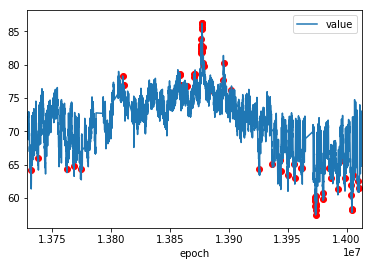

In [28]:
plt.figure()
df.plot(x='epoch', y='value')
plt.scatter(x=df.loc[df['anomaly'] == -1, 'epoch'], y=df.loc[df['anomaly'] == -1, 'value'], c='red')

## One-class SVM

To explain this method, we start from the normal SVM to separate two classes:
\begin{equation}
\min_{w, b, \xi_i}\frac{1}{2}\lVert{w}\rVert^2 + C\sum_{i=1}^N \xi_i \\
\text{subject to} \\
y_i(w\cdot\phi(x_i) + b) \geq 1-\xi_i, \quad \forall i \in \{1, \cdots, N\}  \\
 \xi_i \geq 0, \quad  \forall i \in \{1, \cdots, N\}
\end{equation}

We use $\phi(x_i)$ to denote sample in the feature space. In one-class SVM, we treat all training samples as in class $y=+1$, whereas the origin (0 in the feature space) is in class $y=-1$. The goal is to learn the hyperplane that separates all training samples from the origin. Directly applying this requirement to the above problem, we have
\begin{equation}
\min_{w, b, \xi_i}\frac{1}{2}\lVert{w}\rVert^2 + C\sum_{i=1}^N \xi_i \\
\text{subject to} \\
w\cdot\phi(x_i) + b \geq 1-\xi_i, \quad \forall i \in \{1, \cdots, N\}  \\
 \xi_i \geq 0, \quad  \forall i \in \{1, \cdots, N\}
\end{equation}

The problem with this representation is that, the hyperplane can be as far away as possible from the training samples, because we haven't integrated any sample in the other class. So, to account for that, we introduce another requirement in one-class SVM: in addition, **maximize the distance from the origin to the hyperplane**. The distance from the origin to the hyperplane is: $-b$. (Note that $y=-1$ for the origin.) Hence, we will denote 
$$\rho = 1 - b$$
$$C = \frac{1}{\nu n}$$

Then, the problem becomes
\begin{equation}
\min_{w, b, \xi_i}\frac{1}{2}\lVert{w}\rVert^2 + \frac{1}{\nu n}\sum_{i=1}^N \xi_i - \rho\\
\text{subject to} \\
w\cdot\phi(x_i) \geq \rho -\xi_i, \quad \forall i \in \{1, \cdots, N\}  \\
 \xi_i \geq 0, \quad  \forall i \in \{1, \cdots, N\}
\end{equation}

$-\rho$ in the objective will maximize the distance from the origin to the hyperplane. $\nu$ represents two meanings:
- It sets an upper bound on the fraction of outliers in the training samples.
- It is a lower bound on the number of training examples used as Support Vector. ***Why lower bound?*** Outliers are on the other side of the hyperplane, meaning that they are a subset of the support vectors; **remember** that support vectors include samples on the margin, samples inside the band, and samples totally on the wrong side of the band.

In [29]:
df['anomaly'] = 0
df['anomaly'].value_counts()

0    7267
Name: anomaly, dtype: int64

In [30]:
from sklearn.svm import OneClassSVM

data = df[['value', 'hour', 'daylight', 'dayofweek', 'weekday']]
data = (data - data.mean()) / data.std()

one_svm = OneClassSVM(nu = outliers_fraction)
one_svm.fit(data.values)
svm_pred = one_svm.predict(data.values)
df['anomaly'] = svm_pred

In [31]:
df['anomaly'].value_counts()

 1    7190
-1      77
Name: anomaly, dtype: int64

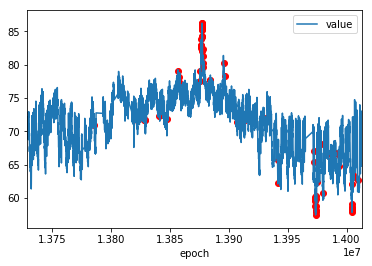

In [32]:
plt.figure()
df.plot(x='epoch', y='value')
plt.scatter(x=df.loc[df['anomaly'] == -1, 'epoch'], y=df.loc[df['anomaly'] == -1, 'value'], c='red')

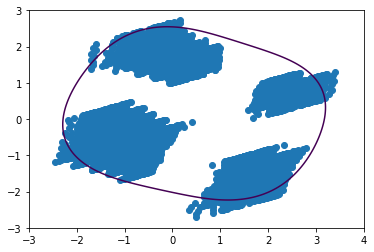

In [33]:
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data.values)

xx, yy = np.meshgrid(np.linspace(-3, 4, 200), np.linspace(-3, 3, 200))
Z = one_svm.decision_function(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

plt.scatter(data_2d[:, 0], data_2d[:, 1])
plt.contour(xx, yy, Z, levels=[0])

## RNN

#### Use for sequential anomalies

In [35]:
df.head()

,timestamp,value,hour,dayofweek,celsius,epoch,distance,anomaly,daylight,weekday
0,2013-07-04 00:00:00,69.880835,0,3,21.044908,13728960,0.809910,1,0,1
1,2013-07-04 01:00:00,71.220227,1,3,21.789015,13728996,0.850494,1,0,1
2,2013-07-04 02:00:00,70.877805,2,3,21.598781,13729032,0.693620,1,0,1
3,2013-07-04 03:00:00,68.959400,3,3,20.533000,13729068,0.349875,1,0,1
4,2013-07-04 04:00:00,69.283551,4,3,20.713084,13729104,0.250676,1,0,1


In [37]:
StandardScaler().fit_transform(df[['value', 'hour']])

array([[-0.32058581, -1.66153683],
       [-0.00522828, -1.51717197],
       [-0.08585098, -1.37280711],
       ..., 
       [ 0.18933168,  0.21520635],
       [ 0.13721779,  0.35957121],
       [ 0.31589058,  0.50393607]])